1. Identify when the  plant is open/operational 
2. Identify the continous data with 1 min time stamp,throw the data which have mtime stamp more than 1min that prev data
3. Apply the algo and will determine the lag ,(period over which we can consider the good data)to determine good data.


In [23]:
import pandas as pd
import numpy as np
import math
import os
import sys
import datetime

from scipy.spatial.distance import pdist, squareform
from scipy.fftpack import fft
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dates
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 4.0) # set default size of plots
import matplotlib.pyplot as plt

C:\Users\ibner\AppData\Local\Temp\ipykernel_23544\3796914203.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [25]:
## Read data 
FILE = 'data.csv'
df = pd.read_csv(FILE, sep = ",", header = 0)
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')
df = df.set_index('time')
df.head()

C:\Users\ibner\AppData\Local\Temp\ipykernel_23544\738780820.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].apply(pd.to_numeric, errors = 'coerce')


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
time,,,,,,
2017-01-01 00:00:00,867.63,910.42,-189.54,-186.04,852.13,-145.90
2017-01-01 00:05:00,879.23,918.14,-184.33,-182.10,862.53,-149.76
2017-01-01 00:10:00,875.67,924.18,-181.26,-166.47,866.06,-145.01
2017-01-01 00:15:00,875.28,923.15,-179.15,-174.83,865.85,-142.82
2017-01-01 00:20:00,891.66,934.26,-178.32,-173.72,876.06,-143.39


Text(0, 0.5, '% Missing Values')

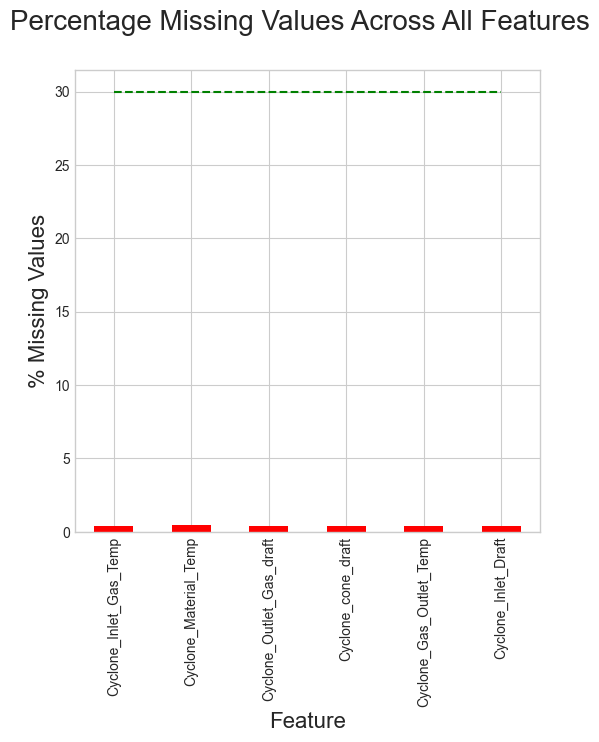

In [13]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 30
fig = plt.figure(figsize=(6, 6))
percent_missing = (df.isna().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--') 
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 20)
plt.xlabel('Feature', fontsize = 16)
plt.ylabel('% Missing Values', fontsize = 16)

In [26]:
## Linear interpolation for one column
#df['Cyclone_Inlet_Gas_Temp'] = df['Cyclone_Inlet_Gas_Temp'].interpolate(method = 'linear')
df.loc[:, (df.columns != 'time')] = df.loc[:, df.columns != 'time'].interpolate(method = 'linear')
(df.isna().sum() / df.shape[0]) * 100

Cyclone_Inlet_Gas_Temp      0.0
Cyclone_Material_Temp       0.0
Cyclone_Outlet_Gas_draft    0.0
Cyclone_cone_draft          0.0
Cyclone_Gas_Outlet_Temp     0.0
Cyclone_Inlet_Draft         0.0
dtype: float64

In [15]:
## Data preparation for anomaly detection
feature = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
sampling_period = 5*60 # in seconds of the dataset as provided
time_period =  12*60*60 # time duration in seconds corresoponding to each sample, in this case 12 hours
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['identity'].fit_transform(df))
df_transformed.index = df.index.copy()
df_transformed.columns = df.columns.copy()
df_anomaly = df_transformed.groupby(pd.Grouper(freq = str(time_period)+'S')).apply(lambda x: x[feature].values if len(x[feature].values) == int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds()) else np.nan)
df_anomaly = df_anomaly.dropna()
df_anomaly.head()

time
2017-01-01 00:00:00    [867.63, 879.23, 875.67, 875.28, 891.66, 878.5...
2017-01-01 12:00:00    [867.67, 894.24, 868.19, 897.61, 858.37, 886.0...
2017-01-02 00:00:00    [874.96, 911.36, 871.52, 902.01, 890.17, 923.8...
2017-01-02 12:00:00    [886.09, 910.84, 876.72, 920.58, 874.44, 909.9...
2017-01-03 00:00:00    [895.79, 890.98, 885.45, 907.22, 880.65, 882.1...
dtype: object

In [17]:
df_transformed.loc[145:0:-1, feature]

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [0] of type int

In [18]:
## Data preparation for autoregression
feature = df.columns[0] # "Cyclone_Inlet_Gas_Temp"
# Sampling period of the dataset in seconds
sampling_period = 5*60
# Lag in seconds for autoregression (in this case, we regress on the past 12 hours):
# change this for last 6 hours, 2 hours, 0.5 hours etc
lag = 7*24 #
lag = lag*60*60
scaler = {'identity': FunctionTransformer(lambda x: x), 'standard': StandardScaler()}
df_transformed = pd.DataFrame(scaler['identity'].fit_transform(df))
df_transformed.columns = df.columns.copy()
df_transformed = df_transformed.reset_index().drop(columns = ['time'])
# Number of columns and rows in the dataframe for performing autoregression
nCols = int(pd.Timedelta(str(time_period/sampling_period)+'S').total_seconds())
print(nCols)
nRows = int(df_transformed.shape[0]/nCols)-1
print(nRows)
# Create dataframe for autoregression
df_autoreg = pd.DataFrame(index = np.arange(nRows), columns = np.arange(nCols+1))
for j in range(nRows):
  df_autoreg.iloc[j, :] = pd.DataFrame([df_transformed.loc[j+nCols, feature]] + df_transformed.loc[(j+nCols-1):j:-1, feature].to_list()).T
df_autoreg

144
2622


,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,867.67,894.03,874.13,885.43,874.63,906.96,900.41,878.01,880.37,897.16,...,905.46,871.01,877.83,905.94,878.54,891.66,875.28,875.67,879.23,867.63
1,894.24,867.67,894.03,874.13,885.43,874.63,906.96,900.41,878.01,880.37,...,875.11,905.46,871.01,877.83,905.94,878.54,891.66,875.28,875.67,879.23
2,868.19,894.24,867.67,894.03,874.13,885.43,874.63,906.96,900.41,878.01,...,901.2,875.11,905.46,871.01,877.83,905.94,878.54,891.66,875.28,875.67
3,897.61,868.19,894.24,867.67,894.03,874.13,885.43,874.63,906.96,900.41,...,874.51,901.2,875.11,905.46,871.01,877.83,905.94,878.54,891.66,875.28
4,858.37,897.61,868.19,894.24,867.67,894.03,874.13,885.43,874.63,906.96,...,882.43,874.51,901.2,875.11,905.46,871.01,877.83,905.94,878.54,891.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,859.33,865.54,874.18,873.36,880.86,872.29,884.62,876.36,873.41,864.43,...,884.48,881.74,860.13,865.74,872.77,863.95,862.38,868.14,874.38,880.23
2618,866.85,859.33,865.54,874.18,873.36,880.86,872.29,884.62,876.36,873.41,...,880.34,884.48,881.74,860.13,865.74,872.77,863.95,862.38,868.14,874.38
2619,898.05,866.85,859.33,865.54,874.18,873.36,880.86,872.29,884.62,876.36,...,863.01,880.34,884.48,881.74,860.13,865.74,872.77,863.95,862.38,868.14
2620,864.64,898.05,866.85,859.33,865.54,874.18,873.36,880.86,872.29,884.62,...,855.71,863.01,880.34,884.48,881.74,860.13,865.74,872.77,863.95,862.38


In [ ]:
# # Lasso regression
# X_train = df_autoreg.iloc[:, 1:]
# y_train = df_autoreg.iloc[:, 0]
# print(y_train)
# # Regression strength
# alpha_lasso = 0.5
# model_lasso =  Lasso(alpha = alpha_lasso)
# model_lasso.fit(X_train, y_train)
# # Print lasso intercept
# #Independent term in decision function.


# print(model_lasso.intercept_)  
# # Print lasso coefficients
# #coef_ndarray of shape (n_features,) or (n_targets, n_features)
# #Parameter vector (w in the cost function formula).
# print(model_lasso.coef_)
# len(model_lasso.coef_)


In [19]:
## Lasso regression
X_train = df_autoreg.iloc[:, 1:]
y_train = df_autoreg.iloc[:, 0]
print(y_train)
# Regression strength
alpha_lasso = 0.5
model_lasso =  Lasso(alpha = alpha_lasso)
model_lasso.fit(X_train, y_train)
# Print lasso intercept
print(model_lasso.intercept_)  
# Print lasso coefficients
print(model_lasso.coef_)
len(model_lasso.coef_)

0       867.67
1       894.24
2       868.19
3       897.61
4       858.37
         ...  
2617    859.33
2618    866.85
2619    898.05
2620    864.64
2621    894.43
Name: 0, Length: 2622, dtype: object
105.65727652233068
[-1.21192791e-01  5.46984525e-01  1.20289691e-01  5.32445721e-04
  5.20234861e-02  2.50044512e-03  4.15070035e-02  2.23462229e-02
  4.05147813e-02  3.15986119e-02  1.91540414e-02 -1.19136992e-02
 -4.31064455e-02 -1.79717156e-02  3.67152559e-03  4.03788501e-02
  5.43392213e-02  4.93673457e-02  0.00000000e+00 -5.13522549e-03
 -0.00000000e+00  1.32194442e-02  1.58841094e-02  0.00000000e+00
 -4.10368216e-03 -0.00000000e+00  9.37630273e-03 -0.00000000e+00
 -2.69634469e-03  5.29719368e-03  5.69804366e-03 -7.36281224e-03
  0.00000000e+00  8.34885619e-03 -2.25646785e-02 -3.05653509e-03
 -2.74046128e-02 -1.25457447e-03 -1.00178285e-02  1.61745865e-02
  1.61532770e-02  1.04434715e-02 -1.10602803e-02  2.86748734e-02
 -5.61393539e-03 -1.38556661e-02 -1.25981556e-02 -5.34085809e-03

144

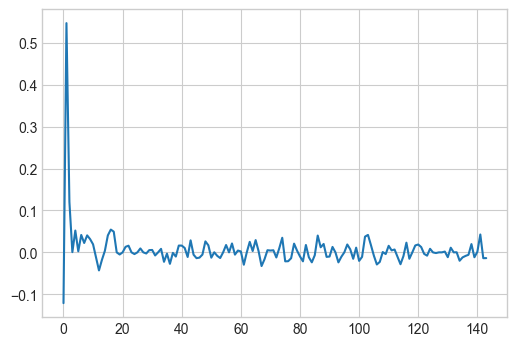

In [22]:
data= model_lasso.coef_
x_coordinate = [ i for i in range(len(data)) ]
plt.plot(x_coordinate,data)
plt.show()


